In [1]:
from pyspark.sql import SparkSession

nyc_taxi_challenge_path = '../../nyc-taxi-challenge/'

spark = SparkSession.builder.appName("NYC Taxi Challenge").getOrCreate()
spark

# Exploring the datasets

Altought this exploration notebook was done using Spark due to its ease at loading data without any schema defined. It shorts the beggining of our learning curve. The data pipelines implementations was done using Airflow + Redshift.


## Trips from 2009

This dataset has informations about taxi trips of 2009

In [2]:
json_2011_trips = nyc_taxi_challenge_path + 'datasets/data-sample_data-nyctaxi-trips-2012-json_corrigido.json'
#json_trips = nyc_taxi_challenge_path + 'datasets/data-sample_data-nyctaxi-trips-*'
trips_df = spark.read.json(json_2011_trips)

trips_df.limit(100).toPandas()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2012-06-09T16:31:19.862787+00:00,40.747950,-73.994712,5.4,2,Cash,2012-06-09T16:21:13.580003+00:00,40.742950,-74.004114,None,None,0.0,0.00,0.00,5.40,0.80,CMT
1,2012-08-14T21:54:50.01863+00:00,40.792385,-73.940449,15.4,1,Cash,2012-08-14T21:44:14.940659+00:00,40.747784,-73.996506,None,None,0.0,0.00,0.00,15.40,5.40,CMT
2,2012-07-06T17:22:57.404442+00:00,40.768108,-73.944535,6.1,5,CASH,2012-07-06T17:12:07.862531+00:00,40.752070,-73.951340,None,None,1.0,0.00,0.00,7.10,1.67,VTS
3,2012-07-22T04:20:45.142945+00:00,40.721812,-73.958122,12.9,1,CASH,2012-07-22T04:12:28.704958+00:00,40.729128,-74.001117,None,None,0.5,0.00,0.00,13.40,4.13,VTS
4,2012-07-11T11:49:03.034108+00:00,40.776075,-73.979757,7.7,1,CASH,2012-07-11T11:40:13.77461+00:00,40.756873,-73.976600,None,None,0.5,0.00,0.00,8.20,2.03,VTS
5,2012-09-18T08:11:57.381861+00:00,40.750478,-73.978623,6.5,1,CASH,2012-09-18T08:04:16.536019+00:00,40.750528,-73.994665,None,None,0.0,0.00,0.00,6.50,1.15,VTS
6,2012-07-28T06:10:05.57054+00:00,40.774042,-73.870838,22.1,1,CASH,2012-07-28T06:04:10.057143+00:00,40.772843,-73.955462,None,None,0.0,0.00,4.15,26.25,8.61,VTS
7,2012-03-06T09:17:08.719709+00:00,40.759317,-73.985112,5.7,5,Credit,2012-03-06T09:05:40.958118+00:00,40.757998,-73.976158,None,None,0.0,2.00,0.00,7.70,0.84,VTS
8,2012-03-28T19:54:01.039056+00:00,40.761585,-73.975072,6.1,2,CASH,2012-03-28T19:46:58.45386+00:00,40.764408,-73.988585,None,None,0.0,0.00,0.00,6.10,1.04,VTS
9,2012-10-17T11:43:49.819286+00:00,40.747330,-73.993722,3.7,5,CASH,2012-10-17T11:28:59.571708+00:00,40.740683,-74.001978,None,None,0.0,0.00,0.00,3.70,0.75,VTS


## Payment lookup

This one is of payment lookup's:

In [3]:
from pyspark.sql.functions import col

csv_payment_lookup = nyc_taxi_challenge_path + 'datasets/data-payment_lookup-csv.csv'
payment_lookup_df = (
    spark.read
        .format('csv')
        .option('header', True)
        .load(csv_payment_lookup)
        .filter(col('A') != 'payment_type')
        .withColumnRenamed('A', 'payment_type')
        .withColumnRenamed('B', 'payment_lookup')
)

payment_lookup_df.limit(100).toPandas()

,payment_type,payment_lookup
0,Cas,Cash
1,CAS,Cash
2,Cre,Credit
3,CRE,Credit
4,No,No Charge
5,Dis,Dispute
6,Cash,Cash
7,CASH,Cash
8,Credit,Credit
9,CREDIT,Credit


## Vendor lookup

This is the vendor's lookup dataset:

In [4]:
from pyspark.sql.functions import col

csv_vendor_lookup = nyc_taxi_challenge_path + 'datasets/data-vendor_lookup-csv.csv'
vendor_lookup_df = (
    spark.read
        .format('csv')
        .option('header', True)
        .load(csv_vendor_lookup)
)

vendor_lookup_df.limit(100).toPandas()

,vendor_id,name,address,city,state,zip,country,contact,current
0,CMT,"Creative Mobile Technologies, LLC",950 4th Road Suite 78,Brooklyn,NY,11210,USA,contactCMT@gmail.com,Yes
1,VTS,VeriFone Inc,26 Summit St.,Flushing,NY,11354,USA,admin@vtstaxi.com,Yes
2,DDS,"Dependable Driver Service, Inc",8554 North Homestead St.,Bronx,NY,10472,USA,9778896500,Yes
3,TS,Total Solutions Co,Five Boroughs Taxi Co.,Brooklyn,NY,11229,USA,mgmt@5btc.com,Yes
4,MT,Mega Taxi,4 East Jennings St.,Brooklyn,NY,11228,USA,contact@megataxico.com,No


## Creating SQL views

In [5]:
trips_df.registerTempTable("trips")
payment_lookup_df.registerTempTable("payment_lookups")
vendor_lookup_df.registerTempTable("vendor_lookups")

# Questions

Queremos que, a partir dos dados disponibilizados, você responda, de preferência com gráficos às seguintes questões:

1. Qual a distância média percorrida por viagens com no máximo 2 passageiros;
2. Quais os 3 maiores ​vendors​ em quantidade total de dinheiro arrecadado;
3. Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro;
4. Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.

## Distância média percorrida por viagens com no máximo 2 passageiros

In [12]:
from pyspark.sql.functions import (col, to_timestamp, to_date, date_format)
from pyspark.sql import Window

avg_distance = spark.sql("""
    SELECT
        TO_DATE(pickup_datetime_ts, 'yyyy-MM-dd') AS pickup_date,
        DATE_FORMAT(TO_DATE(pickup_datetime_ts, 'yyyy-MM-dd'), 'yyyy') AS pickup_year,
        avg(trip_distance) AS avg_trip_distance
    FROM
        (SELECT 
            trip_distance,
            passenger_count,
            TO_TIMESTAMP(pickup_datetime, "yyyy-MM-dd'T'HH:mm:ss") AS pickup_datetime_ts
         FROM
            trips
         WHERE
             passenger_count <= 2
        ) AS tmp_trips
    GROUP BY
        1,2
""")

# avg_distance = (
#     trips_df.filter(col('passenger_count') <= 2)
#         .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
#         .withColumn('pickup_date', to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'))
#         .withColumn('pickup_year', date_format(col('pickup_date'), 'yyyy'))
#         .select(
#             col('pickup_year'),
#             col('pickup_date'), 
#             col('trip_distance')
#         )
#         .groupBy('pickup_year', 'pickup_date')
#         .avg()
# )
avg_distance.limit(10).toPandas()

,pickup_date,pickup_year,avg_trip_distance
0,2012-04-24,2012,2.593142
1,2012-01-15,2012,2.639855
2,2012-10-19,2012,2.694224
3,2012-05-12,2012,2.726214
4,2012-10-09,2012,2.693520
5,2012-04-17,2012,2.667261
6,2012-09-21,2012,2.755474
7,2012-09-11,2012,2.807814
8,2012-09-30,2012,2.670981
9,2012-01-29,2012,2.610340


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.plotting.register_matplotlib_converters()

avg_distance_pd = avg_distance.toPandas().sort_values(by=['pickup_year', 'pickup_date'])
# avg_distance_pd.plot(x='pickup_date',y='avg(trip_distance)')

def pie(v, l, color=None):
    plt.plot(l.values, v)
g = sns.FacetGrid(avg_distance_pd, col="pickup_year")
g.map(pie, "avg_trip_distance", "pickup_date" )

plt.show()

<Figure size 300x300 with 1 Axes>

## Os 3 maiores vendors em quantidade total de dinheiro arrecadado

In [7]:
from pyspark.sql.functions import (col)
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def pickup_semester(yearMonth):
    return str(yearMonth.year) + '-' + ('1' if yearMonth.month <= 6 else '2')

pickup_semester_udf = udf(pickup_semester, StringType())

revenue_per_vendor = (
    trips_df
            .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('pickup_semester', pickup_semester_udf(to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd')))
            .select(
                col('pickup_semester'),
                col('vendor_id'),
                col('total_amount')
            )
            .groupBy('vendor_id', 'pickup_semester')
            .sum()
)

revenue_per_vendor_pd = revenue_per_vendor.toPandas().sort_values(by=['pickup_semester', 'vendor_id'])
revenue_per_vendor_pd

,vendor_id,pickup_semester,sum(total_amount)
6,CMT,2012-1,2942198.56
1,DDS,2012-1,411102.50
2,VTS,2012-1,2873966.68
5,CMT,2012-2,1945072.51
4,DDS,2012-2,267622.93
0,TS,2012-2,11.40
3,VTS,2012-2,1886891.82


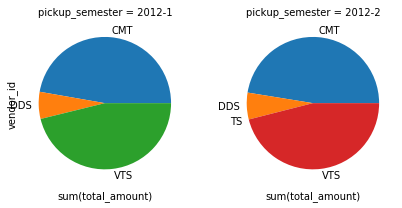

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# values = revenue_per_vendor_pd['sum(total_amount)']
# labels = revenue_per_vendor_pd['vendor_id']
# semesters = revenue_per_vendor_pd['pickup_semester']

def pie(v, l, color=None):
    plt.pie(v, labels=l.values)
g = sns.FacetGrid(revenue_per_vendor_pd, col="pickup_semester")
g.map(pie, "sum(total_amount)", "vendor_id" )

plt.show()

## Histograma da distribuição mensal (nos 4 anos) de corridas pagas em dinheiro

In [9]:
from pyspark.sql.functions import (col, lower, date_format)

monthly_cash_revenues = (
    trips_df
            .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('pickup_month', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM'), 'yyyy-MM'))
            .withColumn('payment_type', lower(col('payment_type')))
            .filter(col('payment_type') == 'cash')
            .select(
                col('pickup_month'),
                col('total_amount')
            )
)

In [10]:
gre_histogram = (
    monthly_cash_revenues
        .filter(col('pickup_month') == '2011-03')
        .select('total_amount')
        .rdd.flatMap(lambda x: x).histogram([1,5,10,15,20,25,30,35,40,45,50,55,60])
)

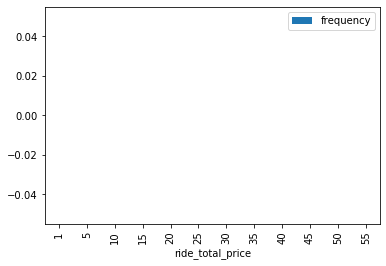

In [11]:
import pandas as pd

pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['ride_total_price', 'frequency']
).set_index(
    'ride_total_price'
).plot(kind='bar')

## Quantidade de gorjetas por dia nos últimos 3 meses de 2012

In [12]:
from pyspark.sql.functions import (col, lower, date_format)

tips_per_day = (
    trips_df
            .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('pickup_year', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'), 'yyyy'))
            .withColumn('pickup_month', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM'), 'yyyy-MM'))
            .withColumn('pickup_date', to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'))
            .where(col('pickup_year') == '2012')
            .where(col('pickup_month').isin(['2012-08', '2012-09', '2012-10']))
            .select(
                col('pickup_month'),
                col('pickup_date'),
                col('tip_amount')
            )
            .groupBy('pickup_month', 'pickup_date')
            .sum()
)

tips_per_day_pd = tips_per_day.toPandas().sort_values(by=['pickup_month', 'pickup_date'])

tips_per_day_pd

,pickup_month,pickup_date,sum(tip_amount)
46,2012-08,2012-08-01,1268.04
53,2012-08,2012-08-02,1473.60
40,2012-08,2012-08-03,1315.18
74,2012-08,2012-08-04,1314.96
9,2012-08,2012-08-05,1297.76
52,2012-08,2012-08-06,1291.31
57,2012-08,2012-08-07,1499.44
72,2012-08,2012-08-08,1370.80
77,2012-08,2012-08-09,1317.54
41,2012-08,2012-08-10,1367.18


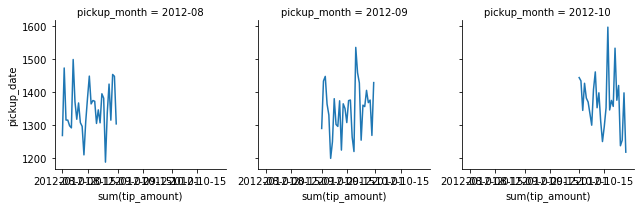

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plt_plot(v, l, color=None):
    plt.plot(l.values, v)
g = sns.FacetGrid(tips_per_day_pd, col="pickup_month")
g.map(plt_plot, "sum(tip_amount)", "pickup_date" )

plt.show()

# Bonus questions


- Qual o tempo médio das corridas nos dias de sábado e domingo;
- Fazer uma visualização em mapa com latitude e longitude de ​pickups and ​dropoffs ​no ano de 2010;
- Simular um ​streaming dos dados dos ​JSON e fazer uma visualização acompanhando uma métrica em tempo-real;
- Conseguir provisionar todo seu ambiente em uma cloud pública, de preferência ​AWS​.

## Tempo médio das corridas nos dias de sábado e domingo

In [17]:
from pyspark.sql.functions import (col, lower, to_timestamp, date_format, to_date, unix_timestamp)

trips_on_weekend = (
    trips_df
            .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('dropoff_datetime_ts', to_timestamp(col('dropoff_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('trip_duration_in_secs', unix_timestamp(col('dropoff_datetime_ts')) - unix_timestamp(col('pickup_datetime_ts')))
#             .withColumn('pickup_year', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'), 'yyyy'))
            .withColumn('pickup_month', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM'), 'yyyy-MM'))
#             .withColumn('pickup_date', to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'))
            .withColumn('pickup_dayofweek', lower(date_format(col('pickup_datetime_ts'), 'EEEE')))
            .where(col('pickup_dayofweek').isin(['saturday', 'sunday']))
            .select(
                col('pickup_month'),
                col('trip_duration_in_secs')
            )
            .groupBy('pickup_month')
            .avg()
            
)

trips_on_weekend.limit(10).toPandas().sort_values(by=['pickup_month'])

,pickup_month,avg(trip_duration_in_secs)
5,2012-01,540.674658
1,2012-02,540.355309
9,2012-03,539.745943
2,2012-04,541.470857
3,2012-05,541.284922
6,2012-06,539.730638
4,2012-07,539.545148
0,2012-08,538.889969
7,2012-09,539.839830
8,2012-10,539.003899


## Visualização em mapa com latitude e longitude de pickups e dropoffs no ano de 2010

In [34]:
!pip install folium

     |████████████████████████████████| 92kB 1.6MB/s eta 0:00:011


In [20]:
from pyspark.sql.functions import (col, lower, to_timestamp, date_format, to_date, unix_timestamp)

trips_per_month = (
    trips_df
            .withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('dropoff_datetime_ts', to_timestamp(col('dropoff_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
#             .withColumn('pickup_year', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'), 'yyyy'))
            .withColumn('pickup_month', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM'), 'yyyy-MM'))
#             .withColumn('pickup_date', to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'))
#             .withColumn('pickup_dayofweek', lower(date_format(col('pickup_datetime_ts'), 'EEEE')))
#             .where(col('pickup_month').isin(['2012-01']))
            .select(
                col('pickup_month'),
                col('pickup_datetime')
            )
            .groupBy('pickup_month')
            .count()
            
)

trips_per_month.limit(10).toPandas().sort_values(by=['pickup_month'])

,pickup_month,count
5,2012-01,99827
1,2012-02,96721
9,2012-03,102953
2,2012-04,100259
3,2012-05,103644
6,2012-06,99855
4,2012-07,103967
0,2012-08,102962
7,2012-09,100063
8,2012-10,89749


In [50]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt


trips_from_2012 = (
    trips_df.withColumn('pickup_datetime_ts', to_timestamp(col('pickup_datetime'), "yyyy-MM-dd'T'HH:mm:ss"))
            .withColumn('pickup_year', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'), 'yyyy'))
            .withColumn('pickup_month', date_format(to_date(col('pickup_datetime_ts'), 'yyyy-MM'), 'yyyy-MM'))
            .withColumn('pickup_date', to_date(col('pickup_datetime_ts'), 'yyyy-MM-dd'))
            .where(col('pickup_month') == '2012-10')
            .select(
                'pickup_latitude',
                'pickup_longitude',
                'dropoff_latitude',
                'dropoff_longitude'
            )
)

trips_from_2012_avg = trips_from_2012.groupBy().avg()

trips_from_2012_pd_df = trips_from_2012.toPandas()

trips_from_2012_avg_pd_df = trips_from_2012_avg.toPandas()

trips_from_2012_avg_pd_df

,avg(pickup_latitude),avg(pickup_longitude),avg(dropoff_latitude),avg(dropoff_longitude)
0,40.125484,-72.832772,40.134515,-72.846357


In [51]:
import folium
from folium import (Map, CircleMarker)
from folium.features import (GeoJson)
from folium.plugins import MarkerCluster


pickup_map = Map(
    location=[
        trips_from_2012_avg_pd_df['avg(pickup_latitude)'].mean(),
        trips_from_2012_avg_pd_df['avg(pickup_longitude)'].mean()
    ],
    tiles='OpenStreetMap',
    zoom_start=12
)


mc = MarkerCluster()

for row in trips_from_2012_pd_df.itertuples():
    mc.add_child(folium.Marker(location=[row.pickup_latitude,  row.pickup_longitude],
                 popup=str(row.pickup_latitude)+','+str(row.pickup_longitude)))
 
pickup_map.add_child(mc)
pickup_map.save(outfile="outputs/pickups_map.html")

# Data visualization improvements

This section will be dedicated to study `matplotlib` with the data from NYC Taxis

In [7]:
!pip install configparser
!pip install psycopg2

     |████████████████████████████████| 378kB 572kB/s eta 0:00:01
  Created wheel for psycopg2: filename=psycopg2-2.8.3-cp37-cp37m-linux_x86_64.whl size=450491 sha256=af9a470355bc1f53fb7de198e33904c8322c295e46af2437524ae4a8120a39f9
  Stored in directory: /home/jovyan/.cache/pip/wheels/48/06/67/475967017d99b988421b87bf7ee5fad0dad789dc349561786b
Successfully built psycopg2


In [10]:
import configparser
import psycopg2

nyc_taxi_challenge_path = '../../nyc-taxi-challenge/dwh.cfg'

config = configparser.ConfigParser()
config.read(nyc_taxi_challenge_path)

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))


## Biannual revenue per vendor

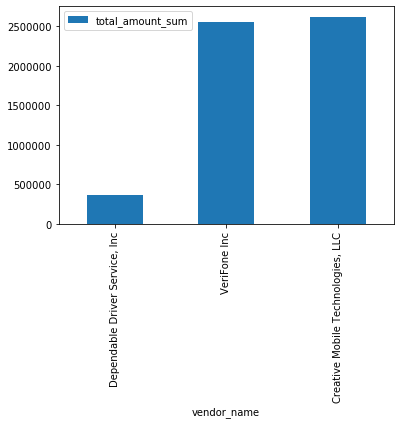

In [12]:
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt

sql_query = """
        SELECT 
            vendor_lookups.name AS vendor_name,
            total_amount_sum
        FROM 
            bi_bianual_revenue_per_vendor
            JOIN vendor_lookups ON (vendor_lookups.vendor_id = bi_bianual_revenue_per_vendor.vendor_id)
        WHERE
            pickup_semester = '{}-{}'
    """.format('2011', '1')

df = sqlio.read_sql_query(sql_query, conn)


df.plot(kind='bar',y='total_amount_sum', x='vendor_name')

plt.show()

## Daily average trip distance in a month

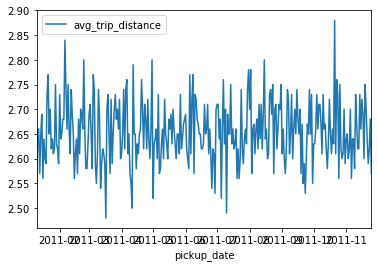

In [15]:
sql_query = """
    SELECT 
        pickup_date,
        avg_trip_distance
    FROM 
        bi_daily_avg_trip_distance
    WHERE
        EXTRACT(yr FROM pickup_date) = {}
""".format('2011')

df = sqlio.read_sql_query(sql_query, conn).sort_values(by='pickup_date')


df.plot(x='pickup_date', y='avg_trip_distance')
plt.show()

## Daily tip amount in a month

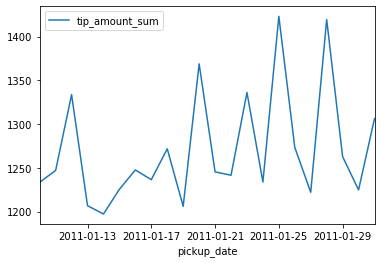

In [20]:
sql_query = """
    SELECT 
        pickup_date,
        tip_amount_sum
    FROM 
        bi_daily_tip_amount
    WHERE
        TO_CHAR(pickup_date, 'YYYY-MM') = '{}-{}'
""".format('2011', '01')

df = sqlio.read_sql_query(sql_query, conn).sort_values(by='pickup_date')

df.plot(y='tip_amount_sum', x='pickup_date')

plt.show()

## Monthly average of weekend trips duration

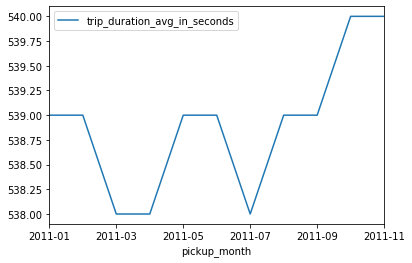

In [21]:
sql_query = """
    SELECT 
        pickup_month,
        trip_duration_avg_in_seconds
    FROM 
        bi_monthly_avg_weekend_trips_duration
    WHERE
        pickup_month LIKE '{}-%'
""".format('2011')

df = sqlio.read_sql_query(sql_query, conn).sort_values(by='pickup_month')

df.plot(x='pickup_month', y='trip_duration_avg_in_seconds')

plt.show()

## Price frequency (a.k.a. histogram)

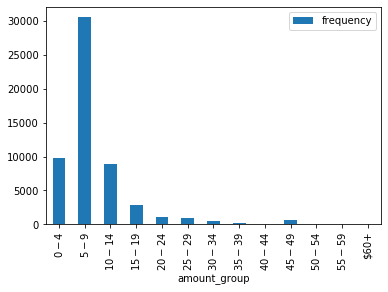

In [24]:
sql_query = """
    SELECT 
        CAST(SPLIT_PART(REPLACE(amount_group, '$', ''), '-', 1) AS NUMERIC) AS amount_group_start_range,
        amount_group,
        frequency
    FROM 
        bi_monthly_price_frequency
    WHERE
        pickup_month = '{}-{}'
    ORDER BY 1
""".format('2011', '01')

df = sqlio.read_sql_query(sql_query, conn)

df.plot(kind='bar', x='amount_group', y='frequency')

plt.show()